# Импорт библиотек

## Импорт библиотек TensorFlow

In [20]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
import pydicom as dicom

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from skimage.transform import resize

# %reload_ext signature
# %matplotlib inline
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
  import warnings
  warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

print('All modules TensorFlow have been imported')




All modules TensorFlow have been imported


## Импорт библиотек PyTorch

In [3]:
!pip install torchsummary torch-summary 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pickle

from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18


import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

from torchsummary import summary

import gc
gc.collect()

import cv2

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

from PIL import Image

import matplotlib.pyplot as plt
from IPython.display import clear_output

from graphviz import Digraph

print('All modules PyTorch have been imported')

All modules PyTorch have been imported


In [5]:
class ASPPBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=(1, 1), in_channels=channels, out_channels=channels, padding=0)
        self.conv2 = torch.nn.Conv2d(kernel_size=(3, 3), in_channels=channels, out_channels=channels, padding=6, dilation=(6, 6))
        #self.conv3 = torch.nn.Conv2d(kernel_size=(3, 3), in_channels=channels, out_channels=channels, padding=12, dilation=(12,12))
        #self.conv4 = torch.nn.Conv2d(kernel_size=(3, 3), in_channels=channels, out_channels=channels, padding=18, dilation=(18,18))
        self.conv5 = torch.nn.Conv2d(kernel_size=(1, 1), in_channels=channels*2, out_channels=channels)
        
    def forward(self, inp):
        out1 = torch.nn.functional.relu(self.conv1(inp))
        #print(f"out1",np.shape(out1))
        out2 = torch.nn.functional.relu(self.conv2(inp))
        #print(f"out2",np.shape(out2))
        #out3 = torch.nn.functional.relu(self.conv3(inp))
        #print(f"out3",np.shape(out3))
        #out4 = torch.nn.functional.relu(self.conv4(inp))
        #print(f"out4",np.shape(out4))
        #out = torch.cat((out1, out2, out3, out4), dim=1)
        out = torch.cat((out1, out2), dim=1)
        #print(f"out",np.shape(out))
        out = torch.nn.functional.relu(self.conv5(out))
        return out

In [6]:
class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(out_channels)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        return out

In [7]:
class Bottlenack(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=in_channels*2, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(in_channels*2)
        self.conv2 = torch.nn.Conv2d(kernel_size=3, in_channels=in_channels*2, out_channels=in_channels*2, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(in_channels*2)
        self.conv3 = torch.nn.ConvTranspose2d(kernel_size=3, in_channels=in_channels*2, out_channels=in_channels,stride=2, padding=1, output_padding=1)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.nn.functional.relu(self.conv3(out))
        return out

In [8]:
class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        mid_channel = min(in_channels, out_channels) + max(in_channels, out_channels) - min(in_channels, out_channels)
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(mid_channel)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(mid_channel)
        self.conv3 = torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.nn.functional.relu(self.conv3(out))
        return out

In [9]:
class FinalBlock(nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, kernel_size=3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(mid_channel)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(mid_channel)
        self.conv3 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.nn.functional.sigmoid(self.conv3(out))
        return out

In [10]:
class UNet(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.conv1 = DownSampling(in_channels, 64, 3)
        self.conv2 = DownSampling(64, 128, 3)
        self.conv3 = DownSampling(128, 256, 3)
        self.bottleneck = Bottlenack(256)
        self.convT1 = UpSampling(in_channels=256,out_channels=192, kernel_size=3)
        self.convT2 = UpSampling(in_channels=192,out_channels=128, kernel_size=3)
        self.convT3 = UpSampling(in_channels=128,out_channels=96,  kernel_size=3)
        self.convT4 = UpSampling(in_channels=96, out_channels=64,  kernel_size=3)
        self.aspp = ASPPBlock(64)
        self.final = FinalBlock(64, 16, out_channels)
        self.conv_maxpool = torch.nn.MaxPool2d(kernel_size=2)
    
    def forward(self, x):
        #print(np.shape(x))
        x = self.conv1(x)
        x = self.conv_maxpool(x)
        #print(f"conv1", np.shape(x))
        x = self.conv2(x)
        x = self.conv_maxpool(x)
        #print(f"conv2", np.shape(x))
        x = self.conv3(x)
        x = self.conv_maxpool(x)
        #print(f"conv3", np.shape(x))
        x = self.bottleneck(x)
        #print(f"bottleneck", np.shape(x))
        x = self.convT1(x)
        #print(f"convT1", np.shape(x))
        x = self.convT2(x)
        #print(f"convT2", np.shape(x))
        x = self.convT3(x)
        #print(f"convT3", np.shape(x))
        x = self.convT4(x)
        #print(f"convT4", np.shape(x))
        #x = self.aspp(x)
        #print(f"aspp", np.shape(x))
        x = self.final(x)
        #print(f"final", np.shape(x))
        return x

In [11]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(1, 5, kernel_size=3),
      nn.Flatten(),
      nn.Linear(26 * 26 * 5, 300),
      nn.ReLU(),
      nn.Linear(300, 64),
      nn.ReLU(),
      nn.Linear(64, 10)
    )

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

## Импорт библиотек Colab

In [12]:
from google.colab import drive
from google.colab import output # библиотеки для подгрузки с google Disk
drive.mount('/content/drive')
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Импортируем обученные модели

## Импорт Модели № 1 (TensorFlow)

In [13]:
### Загрузка модели в новом формате SaveModel

try:
  model_tf = tf.keras.models.load_model('/content/drive/MyDrive/Докт24/3_local_test/model-tf-1')
  print('Модель > TensorFlow < успешно импортирована')
except:
  print('Модель не удалось импортировать')

# почему-то не работает на локальной машине

Модель > TensorFlow < успешно импортирована


In [14]:
### Загрузка модели в старом формате *.h5

try:
  model_tf_h5 = keras.models.load_model('/content/drive/MyDrive/Докт24/3_local_test/model-tf-1.h5')
  print('Модель > TensorFlow *.h5 < успешно импортирована')
except:
  print('Модель *.h5 не удалось импортировать')


Модель > TensorFlow *.h5 < успешно импортирована


## Импорт Модели № 2 (PyTorch)

https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-save-and-load-a-pytorch-model.md

In [15]:
# Saving the model

#save_path = './mlp.pth'
#torch.save(mlp.state_dict(), save_path)


# Loading the model

#mlp = MLP()
#mlp.load_state_dict(torch.load('./mlp.pth'))  #своя модель
#mlp.eval()

FileNotFoundError: ignored

# Загружаем набор данных для теста

In [ ]:
#заглушка - импортируем рандомное изображение
#img_path = '/content/drive/MyDrive/Докт24/2_Lungs/Darwin/lungs/00000484_person820_virus_1456.png'

In [ ]:
#img_path = files.upload()

In [21]:
data_paths = glob('/content/drive/MyDrive/lola11/75d23269adbd' + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print (f'Total of {len(data_paths)} DICOM images.\nFirst 5 filenames:' )
data_paths[:5]

Total of 235 DICOM images.
First 5 filenames:


['/content/drive/MyDrive/lola11/75d23269adbd/1f90c9be6099.dcm',
 '/content/drive/MyDrive/lola11/75d23269adbd/201ad100d45a.dcm',
 '/content/drive/MyDrive/lola11/75d23269adbd/216af16b24f7.dcm',
 '/content/drive/MyDrive/lola11/75d23269adbd/21f421980773.dcm',
 '/content/drive/MyDrive/lola11/75d23269adbd/22ca7f93b65c.dcm']

In [24]:
def load_scan(paths):
    slices = [dicom.read_file(path ) for path in paths]
    slices.sort(key = lambda x: int(x.InstanceNumber), reverse = True)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [31]:
patient_id = '75d23269adbd'
try:
  np.load(f'/content/drive/MyDrive/lola11/fullimages_{patient_id}.npy')
  print('File found')
except:
  print('File not found')
  patient = load_scan(data_paths)
  imgs = get_pixels_hu(patient)
  #This is a good time to save the new data set to disk so we don't have to reprocess the stack every time.
  np.save(f'/content/drive/MyDrive/lola11/fullimages_{patient_id}.npy', imgs)
 

File not found


In [32]:
file_used= f'/content/drive/MyDrive/lola11/fullimages_{patient_id}.npy'
imgs_to_process = np.load(file_used).astype(np.float64) 

#plt.hist(imgs_to_process.flatten(), bins=100, color='c')
#plt.xlabel("Hounsfield Units (HU)")
#plt.ylabel("Frequency")
#plt.show()

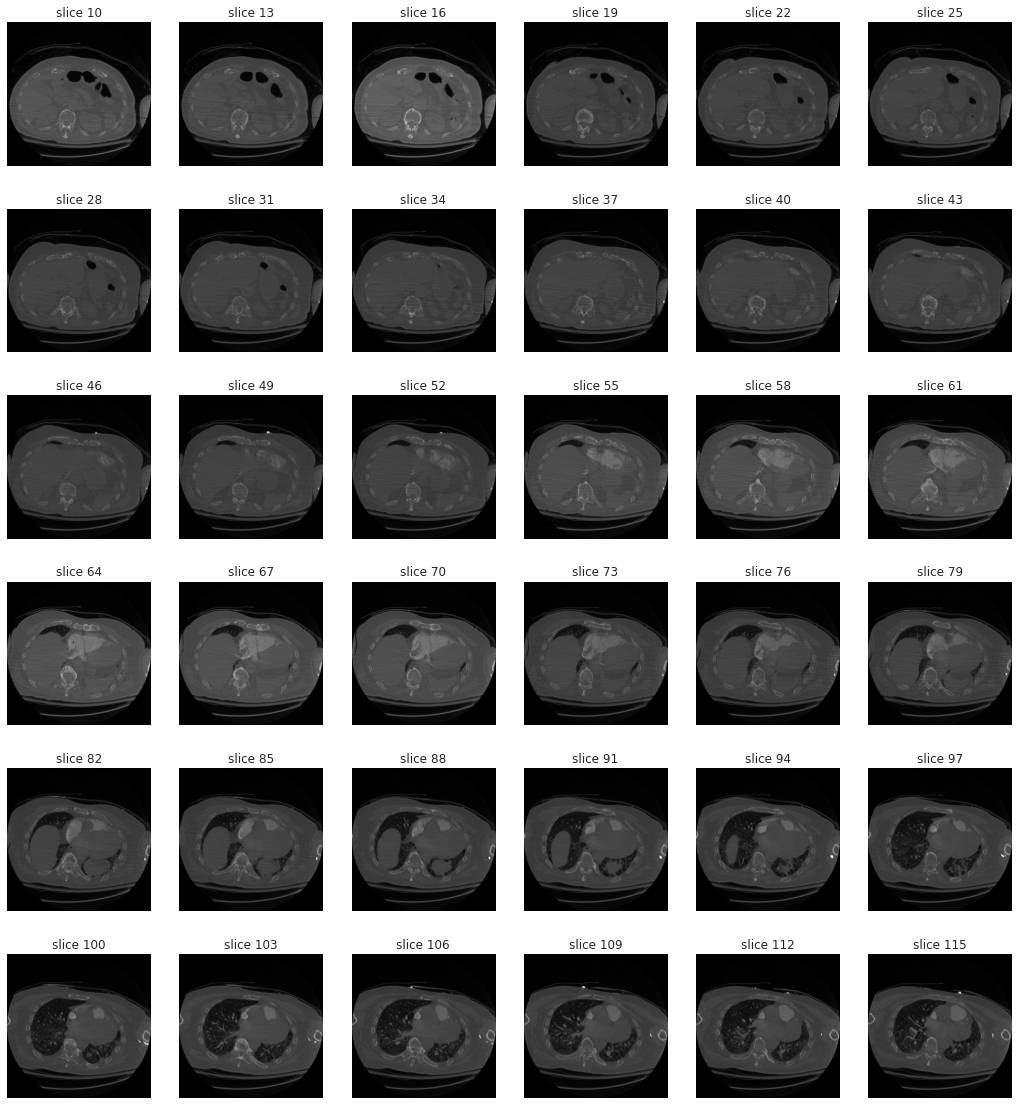

In [34]:
imgs_to_process = np.load(file_used).astype(np.float64) 

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[18,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title(f'slice {ind}')
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [35]:
imgs_to_process = np.load(file_used).astype(np.float64)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
#     spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array([float(patient[0].SliceThickness), 
                        float(patient[0].PixelSpacing[0]), 
                        float(patient[0].PixelSpacing[0])])


    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print(f'Shape before resampling: {imgs_to_process.shape}')
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print(f'Shape after resampling: {imgs_after_resamp.shape}')

Shape before resampling: (235, 512, 512)
Shape after resampling: (294, 411, 411)


## Обрабатываем исходные данные в Модели № 1 (TensorFlow)



In [36]:
class_names=['adenocarcinoma', 'large.cell', 'normal', 'squamous.cell']

img = tf.keras.utils.load_img(img_path, target_size=(300, 440, 3))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = model_tf_h5.predict(img_array)

NameError: ignored

## Обрабатываем исходные данные в Модели № 2 (PyTorch)

# Вывод результатов

## Создаем 3d модель для визуализации



In [37]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True)
    return verts, faces


def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    #colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = ff.create_trisurf(x=x, y=y, z=z, plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
#     ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    ax.set_facecolor((0.7,0.7,0.7))
    plt.show()

Transposing surface
Calculating surface


<ipython-input-37-25953da3e203>:7: FutureWarning:

marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19



Drawing


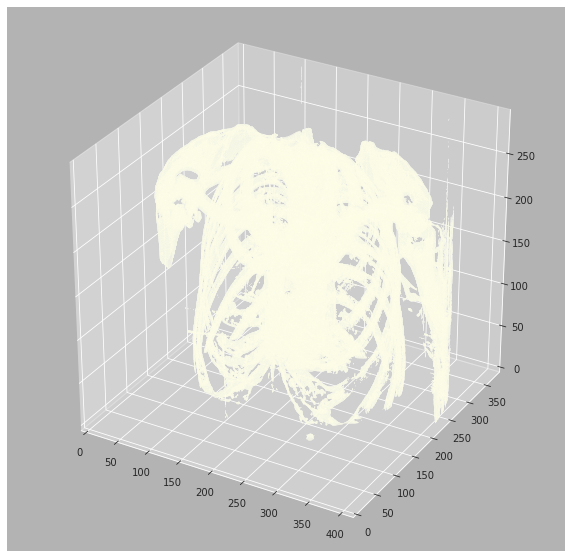

In [38]:
v, f = make_mesh(imgs_after_resamp, threshold = 350) #350 previously default value
plt_3d(v, f)
#plotly_3d(v, f)

In [ ]:
if class_names[np.argmax(prediction)] == 'normal':
  print( 
    "Больше всего похоже на {} с вероятностью {:.2f} %"
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
)
else:
  print( 
    "Больше всего похоже на патологию - {} с вероятностью {:.2f} %"
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
    )
  print( 
    "Есть вероятность расположения патологии в ***"
    )

plt.imshow(img)